# Testing notebook for conjugacy

### Currently (somewhat) implemented features
- Separated Conjugate sampler into more managable ConjugacyPair objects.
- Verification whether the specified conjugacy is supported and/or correct.

### Possible additional improvements
- Support for specifying conjugacy through `sqrtcov` and `sqrtprec`.
    - Through `prec` and `cov` is now supported.
- Allow for more complicated dependancies, e.g.,  a scaled precision matrix `prec = lambda l : l*L`.
    - Regression test that tests for linearity. (Scalar, vector and matrix valued)
- Return the distribution from conjugate


In [1]:
# Load modules and set-up test problem
import sys
sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt

from cuqi.testproblem import Deconvolution1D
from cuqi.distribution import Gaussian, GMRF, Gamma, JointDistribution
from cuqi.implicitprior import RegularizedGaussian, RegularizedGMRF
from cuqi.sampler import LinearRTO, RegularizedLinearRTO, Gibbs, Conjugate, GaussianGammaPair, RegularizedGaussianGammaPair, GammaGammaPair
from cuqi.geometry import Continuous1D

n = 128
A, y_data, info = Deconvolution1D(dim=n, phantom='square').get_components()


In [8]:
a = Gamma(1, 1e-4)
b = Gamma(1, rate = lambda a:2*a)

joint = JointDistribution(a,  b)
target = joint(b = 1)

conjugate = Conjugate(target)
print(conjugate.validate())
print(conjugate.step())

True


ValueError: Output size (1,) is not compatible with broadcast dimensions of inputs (2, 2).

In [4]:
l = Gamma(1, 1e-4)
y = Gaussian(np.zeros(n), prec = lambda l:l*np.eye(n))

joint = JointDistribution(l,  y)
target = joint(y = np.zeros(n))

conjugate = Conjugate(target)
print(conjugate.validate())

True


In [4]:
l = Gamma(1, 1e-4)
y = Gaussian(np.zeros(n), prec = lambda l:1.0/l)

joint = JointDistribution(l,  y)
target = joint(y = np.zeros(n))

conjugate = Conjugate(target)
print(conjugate.validate())


ValueError: Conjugacy on the variable l in attribute prec is not incorrect or unsupported

In [4]:
l = Gamma(1, 1e-4)
y = Gaussian(np.zeros(n), cov = lambda l:1.0/l)

joint = JointDistribution(l,  y)
target = joint(y = np.zeros(n))

conjugate = Conjugate(target)
print(conjugate.validate())


True


In [5]:
l = Gamma(1, 1e-4)
y = Gaussian(mean = lambda l:l*np.ones(n), prec = lambda l:1.0/l, geometry = Continuous1D(n))

joint = JointDistribution(l,  y)
target = joint(y = np.zeros(n))

conjugate = Conjugate(target)
print(conjugate.validate())


ValueError: Conjugate variable l in attribute mean is unsupported.

CUQI GMRF.
CUQI Gaussian.
CUQI GMRF.
CUQI Gaussian.
Warmup 2 / 200CUQI GMRF.
CUQI Gaussian.
CUQI GMRF.
CUQI Gaussian.
Warmup 4 / 200CUQI GMRF.
CUQI Gaussian.
CUQI GMRF.
CUQI Gaussian.
Warmup 6 / 200CUQI GMRF.
CUQI Gaussian.
CUQI GMRF.
CUQI Gaussian.
Warmup 8 / 200CUQI GMRF.
CUQI Gaussian.
CUQI GMRF.
CUQI Gaussian.
Warmup 10 / 200CUQI GMRF.
CUQI Gaussian.
CUQI GMRF.
CUQI Gaussian.
Warmup 12 / 200CUQI GMRF.
CUQI Gaussian.
CUQI GMRF.
CUQI Gaussian.
Warmup 14 / 200CUQI GMRF.
CUQI Gaussian.
CUQI GMRF.
CUQI Gaussian.
Warmup 16 / 200CUQI GMRF.
CUQI Gaussian.
CUQI GMRF.
CUQI Gaussian.
Warmup 18 / 200CUQI GMRF.
CUQI Gaussian.
CUQI GMRF.
CUQI Gaussian.
Warmup 20 / 200CUQI GMRF.
CUQI Gaussian.
CUQI GMRF.
CUQI Gaussian.
Warmup 22 / 200CUQI GMRF.
CUQI Gaussian.
CUQI GMRF.
CUQI Gaussian.
Warmup 24 / 200CUQI GMRF.
CUQI Gaussian.
CUQI GMRF.
CUQI Gaussian.
Warmup 26 / 200CUQI GMRF.
CUQI Gaussian.
CUQI GMRF.
CUQI Gaussian.
Warmup 28 / 200CUQI GMRF.
CUQI Gaussian.
CUQI GMRF.
CUQI Gaussian.
Warmup 30 / 20

Error in callback <function _draw_all_if_interactive at 0x000002850D500860> (for post_execute):


KeyboardInterrupt: 

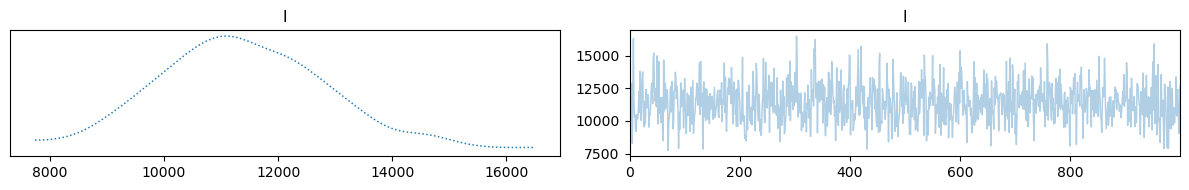

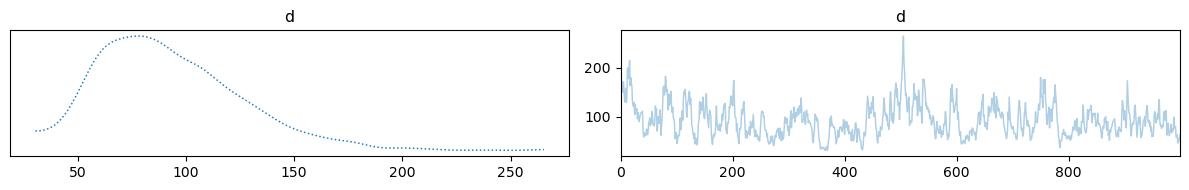

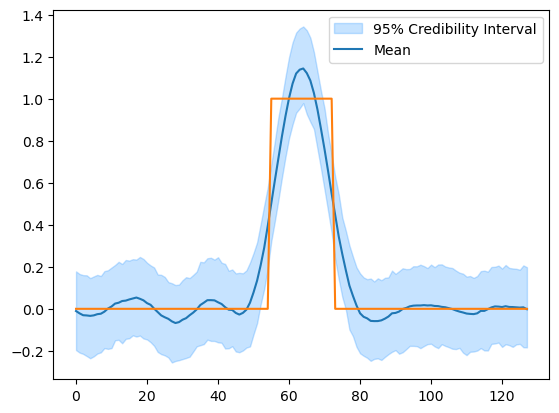

In [3]:
l = Gamma(1, 1e-4)
d = Gamma(1, 1e-4)
x = GMRF(np.zeros(n), prec = lambda d:d)
y = Gaussian(A@x, prec = lambda l:l)

joint = JointDistribution(d, l, x, y)
posterior = joint(y = y_data)

sampling_strategy = {
    'x': LinearRTO,
    'l': Conjugate,
    'd': GaussianGammaPair
}

sampler = Gibbs(posterior, sampling_strategy)
samples = sampler.sample(1000, 200)

samples['l'].plot_trace()
samples['d'].plot_trace()
plt.figure()
samples['x'].plot_ci()
plt.plot(info.exactSolution)

In [7]:
l = Gamma(1, 1e-4)
d = Gamma(1, 1e-4)
x = RegularizedGMRF(np.zeros(n), prec = lambda d:d, constraint="nonnegativity")
y = Gaussian(A@x, prec = lambda l:l)

joint = JointDistribution(d, l, x, y)
posterior = joint(y = y_data)

sampling_strategy = {
    'x': RegularizedLinearRTO,
    'l': RegularizedGaussianGammaPair,
    'd': Conjugate
}

sampler = Gibbs(posterior, sampling_strategy)
samples = sampler.sample(1000, 200)

samples['l'].plot_trace()
samples['d'].plot_trace()
plt.figure()
samples['x'].plot_ci()
plt.plot(info.exactSolution)

ValueError: The likelihood needs to be RegularizedGaussian or RegularizedGMRF, but is <class 'cuqi.distribution._gaussian.Gaussian'>

Warmup 200 / 200
Sample 1000 / 1000


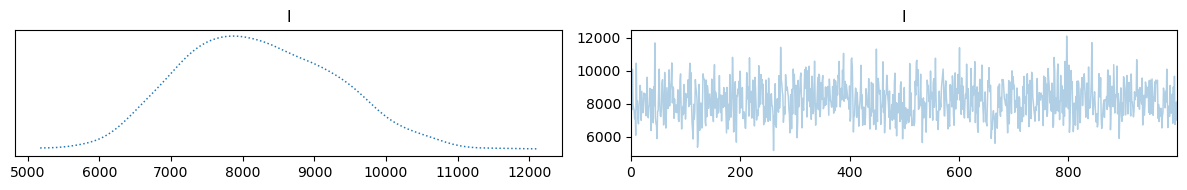

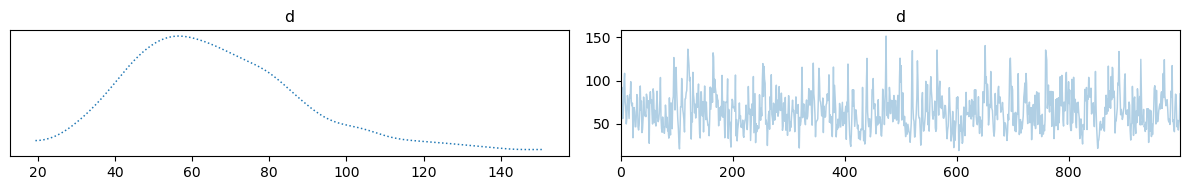

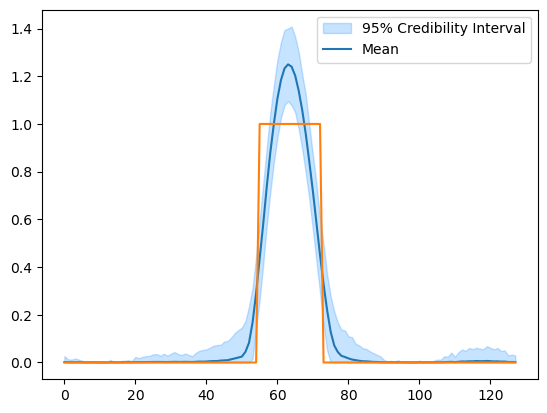

In [8]:
l = Gamma(1, 1e-4)
d = Gamma(1, 1e-4)
x = RegularizedGMRF(np.zeros(n), prec = lambda d:d, constraint="nonnegativity")
y = Gaussian(A@x, prec = lambda l:l)

joint = JointDistribution(d, l, x, y)
posterior = joint(y = y_data)

sampling_strategy = {
    'x': RegularizedLinearRTO,
    'l': GaussianGammaPair,
    'd': RegularizedGaussianGammaPair
}

sampler = Gibbs(posterior, sampling_strategy)
samples = sampler.sample(1000, 200)

samples['l'].plot_trace()
samples['d'].plot_trace()
plt.figure()
samples['x'].plot_ci()
plt.plot(info.exactSolution)